In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from umap import UMAP
import spacy
import re
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from glob import glob

In [2]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

def split_text(text, max_length=100):
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

In [3]:
path = r"C:\Users\Cezary\Documents\Monita-privata\data\konferencja poznań\txt/"
txt_files = [f for f in glob(f"{path}*", recursive=True)]

txt_dict = {}
for txt_file in tqdm(txt_files):
    text_key = txt_file.split('\\')[-1].split('.')[0]
    with open(txt_file, 'rt', encoding='utf-8') as f:
        text_value = f.read()
    txt_dict.update({text_key: text_value})

texts = list(txt_dict.values())

processed_texts = [preprocess_text(text) for text in tqdm(texts)]
split_texts = []
for text in tqdm(processed_texts):
    split_texts.extend(split_text(text))
split_texts = [text for text in split_texts if text.strip() != '']

if len(split_texts) < 2:
    raise ValueError("Niewystarczająca liczba tekstów po przetwarzaniu wstępnym. Dodaj więcej danych wejściowych.")

100%|████████████████████████████████████████████████████████████████████████████████| 322/322 [08:35<00:00,  1.60s/it]


In [7]:
stop_words = list(stopwords.words('english'))

# sentence_model = SentenceTransformer("allegro/herbert-base-cased")
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

class EnglishEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        return self.embedding_model.encode(documents, show_progress_bar=verbose)

english_embedder = EnglishEmbedder(sentence_model)
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.1, metric='cosine')

topic_model = BERTopic(
    embedding_model=english_embedder,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    top_n_words=10,
    n_gram_range=(1, 2),
    min_topic_size=10,
    calculate_probabilities=True
)

try:
    topics, probabilities = topic_model.fit_transform(split_texts)
except ValueError as e:
    print(f"Error during model fitting: {e}")
    print("Texts:", split_texts)
    raise

print(topic_model.get_topic_info())
topic_info = topic_model.get_topic_info()
topic_info.to_csv("data/topics_info.csv", index=False)
print('finished')

    Topic  Count                                     Name   
0      -1   2049                  -1_jesuit_de_study_book  \
1       0    272  0_environmental_access june_june_social   
2       1    166         1_music_musical_song_open access   
3       2    158             2_chinese_china_ricci_jesuit   
4       3    123       3_school_education_student_teacher   
..    ...    ...                                      ...   
73     72     11  72_de procuranda_procuranda_acosta_peru   
74     73     11                     73_et_non_cum_acosta   
75     74     10    74_canillac_mission_istanbul_arsi gal   
76     75     10           75_artist_object_image_chapter   
77     76     10    76_canada_regis_regis college_college   

                                       Representation   
0   [jesuit, de, study, book, jesuits, journal, je...  \
1   [environmental, access june, june, social, sj,...   
2   [music, musical, song, open access, open, acce...   
3   [chinese, china, ricci, jesuit, mat

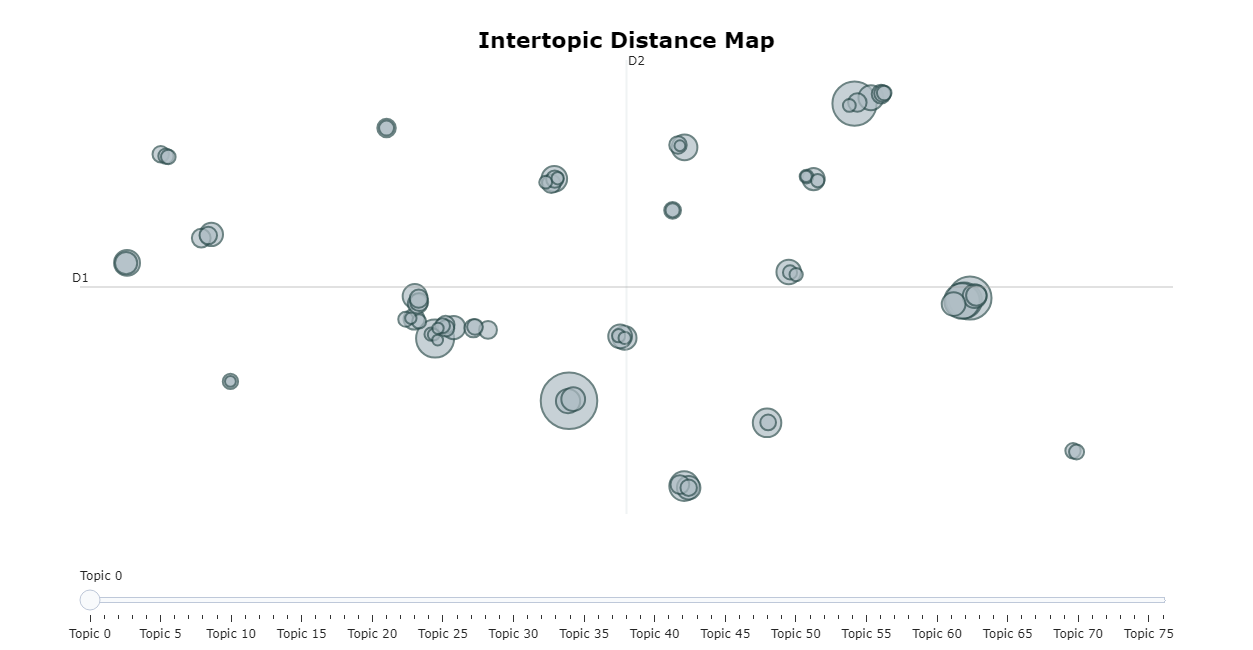

In [8]:
topic_model.visualize_topics()

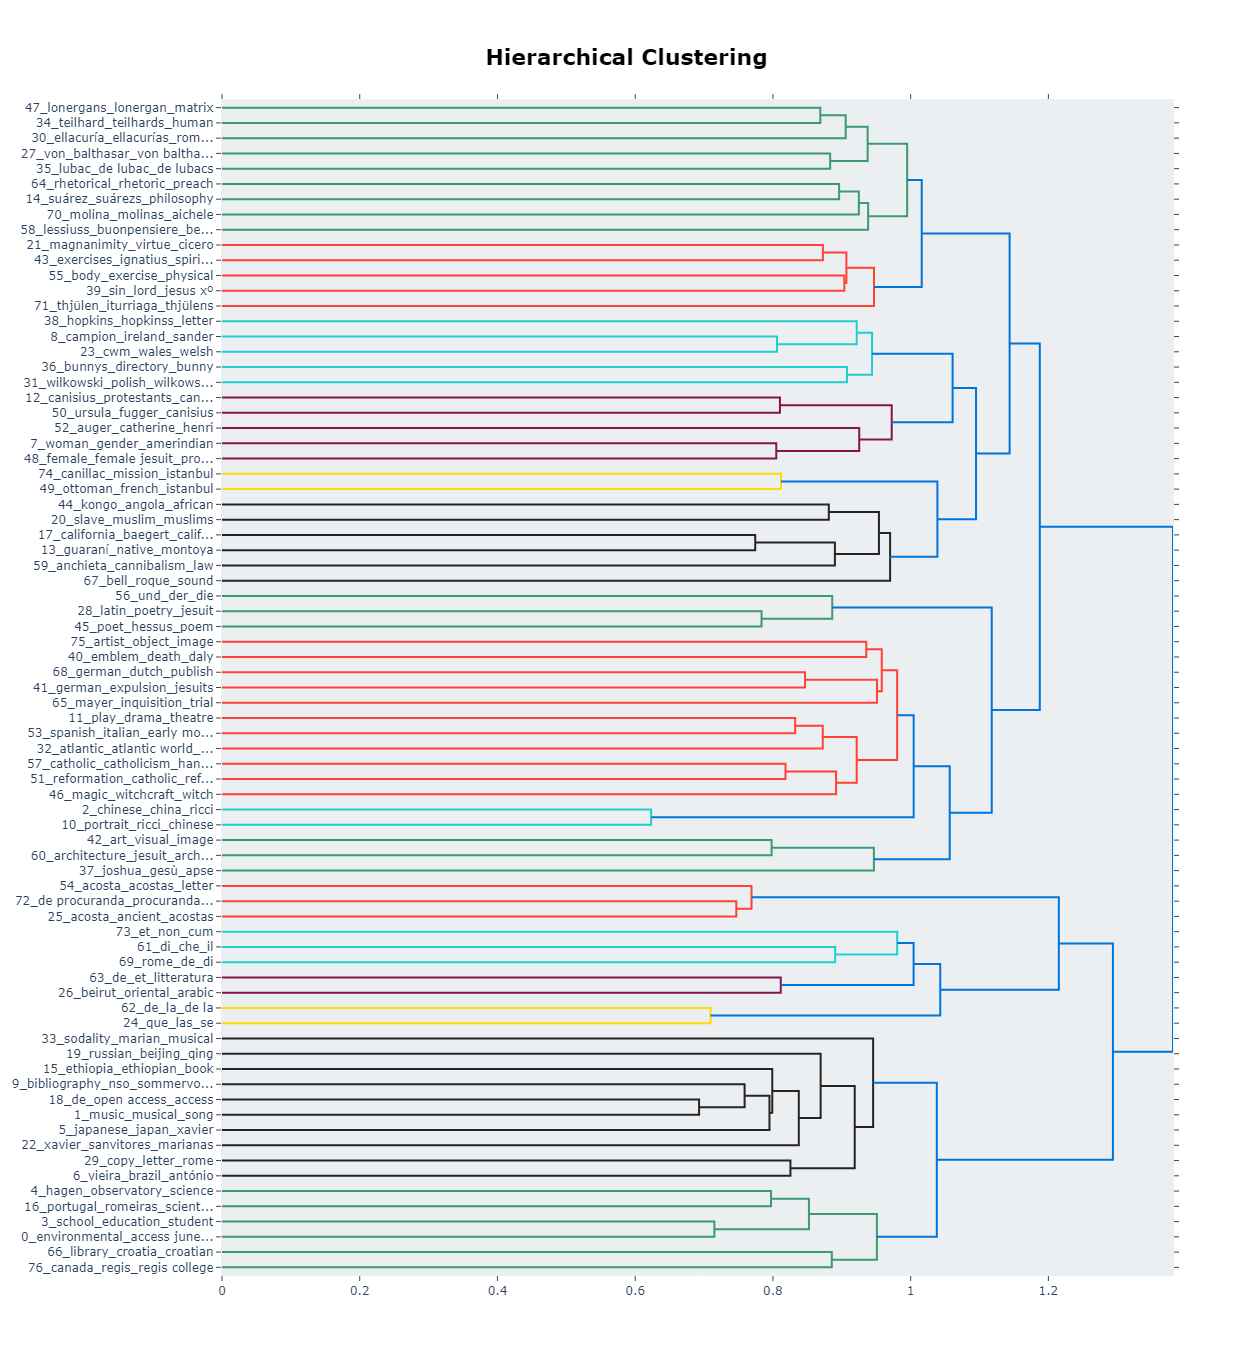

In [14]:
topic_model.visualize_hierarchy()

In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [16]:
hierarchical_topics = topic_model.hierarchical_topics(split_texts)
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 54.32it/s]


.
├─jesuit_study_book_journal_journal jesuit
│    ├─jesuit_study_mission_journal_de
│    │    ├─suárez_human_suárezs_magnanimity_book
│    │    │    ├─suárez_suárezs_von_lubac_de lubac
│    │    │    │    ├─von_lubac_de lubac_lonergans_teilhard
│    │    │    │    │    ├─lonergans_teilhard_lonergan_ellacuría_teilhards
│    │    │    │    │    │    ├─lonergans_teilhard_lonergan_teilhards_human
│    │    │    │    │    │    │    ├─■──lonergans_lonergan_matrix_raymaker_mccarthy ── Topic: 47
│    │    │    │    │    │    │    └─■──teilhard_teilhards_human_consciousness_helminiak ── Topic: 34
│    │    │    │    │    │    └─■──ellacuría_ellacurías_romero_salvador_cerna ── Topic: 30
│    │    │    │    │    └─von_lubac_de lubac_balthasar_von balthasar
│    │    │    │    │         ├─■──von_balthasar_von balthasar_von balthasars_balthasars ── Topic: 27
│    │    │    │    │         └─■──lubac_de lubac_de lubacs_lubacs_grace ── Topic: 35
│    │    │    │    └─suárez_suárezs_cause_lessiuss_moli

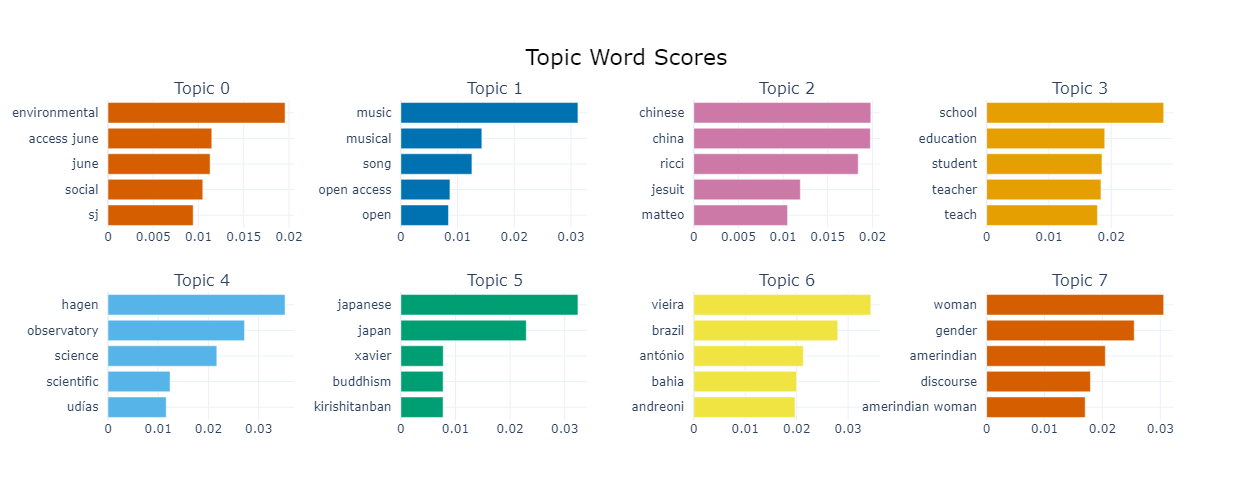

In [17]:
topic_model.visualize_barchart()

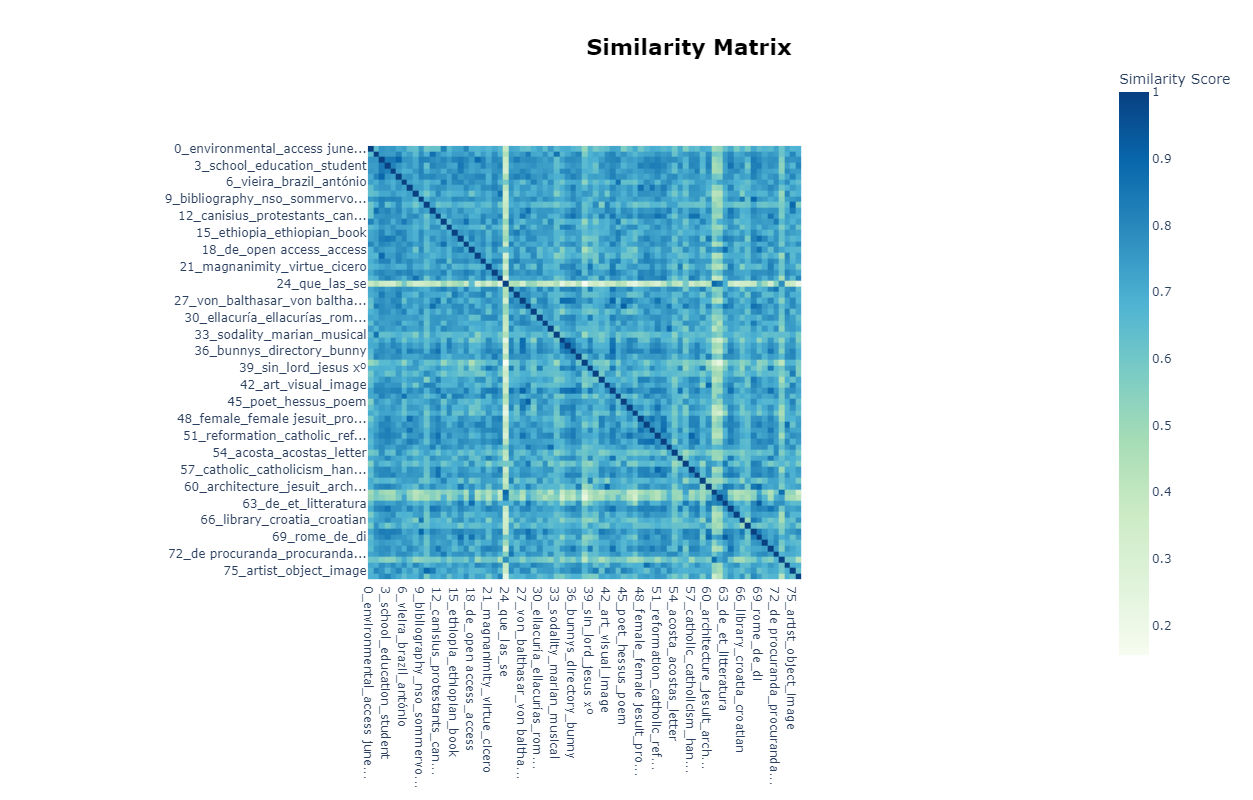

In [18]:
topic_model.visualize_heatmap()